## State-feedback control for discrete-time linear systems

Consider the discrete-time linear system

$$
x_{k+1}=Ax_k+Bu_k,
$$

where $u_k=Kx_k$, is the state-feedback control law.

The goal is to design the gain matrix $K$ by employing the Lyapunov theory. First, close the loop to write

$$
x_{k+1}=Ax_k+BKx_k,
 \quad \mbox{or}, \quad x_{k+1}=(A+BK)x_k.
$$

To provide a stability certificate for the closed-loop system, one must have:

* $V(x_k)>0 \rightarrow x_k^TPx_k>0$, or simply $P>0$.


* ${V}(x_{k+1})-V(x_k)<0 \rightarrow x_{k+1}^TPx_{k+1}- {x}_k^TP{x}_k<0$, or $x_k^T(A+BK)^TP(A+BK)x_k-x_k^TPx_k<0$, which can be written as

$$
(A+BK)^TP(A+BK) - P<0, \quad \mbox{or}, \quad P-(A+BK)^TP(A+BK)>0
$$

$$
P-(A+BK)^TPP^{-1}P(A+BK)>0
$$

By applying the Schur complement yields

$$
\begin{bmatrix}
P & (A+BK)^TP \\
P(A+BK) & P
\end{bmatrix} >0
$$

Perform a congruence transformation

$$
\begin{bmatrix}
P^{-1} & 0 \\
0 & P^{-1}
\end{bmatrix}
\begin{bmatrix}
P & (A+BK)^TP \\
P(A+BK) & P
\end{bmatrix}
\begin{bmatrix}
P^{-1} & 0 \\
0 & P^{-1}
\end{bmatrix}>0,
$$

or simply

$$
\begin{bmatrix}
P^{-1} & P^{-1}(A+BK)^T \\
(A+BK)P^{-1} & P^{-1}
\end{bmatrix}>0.
$$

Let us call $P^{-1}=Q$ to write

$$
\begin{bmatrix}
Q & Q(A+BK)^T \\
(A+BK)Q & Q
\end{bmatrix}>0.
$$

Moreover, the change of variables $KQ=Z$ will be employed.

$$
\begin{bmatrix}
Q & QA^T+Z^TB^T \\
AQ+BZ & Q
\end{bmatrix}>0.
$$

Remember that one must have $P>0$ to guarantee that the Lyapunov function is positive definite. Then, the congruence transformation will be applied to write

$$P^{-1}PP^{-1}>0, \\
P^{-1}>0, \\
Q>0.
$$

At the end of the optimization procedure, we will be able to recover the gain matrix

$$
KQ=Z, \\
KQQ^{-1}=ZQ^{-1}, \\
K=ZQ^{-1}.
$$

### Example

Consider the following discrete-time system.

$$
{x}_{k+1}=\begin{bmatrix} 1 & 1 \\ 0.5 & 1 \end{bmatrix}x_k + \begin{bmatrix} 1 \\ 1 \end{bmatrix}u_k
$$

The system is open-loop unstable. The goal is to design the state-feedback control action $u_k=Kx_k$ such that the closed-loop system $A+BK$ is asymptotic stable.




In [1]:
import cvxpy as cp
import numpy as np

#System matrices
A = np.array([[1.0, 1.0],[0.5,1.0]])
B = np.array([[1.0],[1.0]])
eps=1e-3

#Dimensions
nx=A.shape[0]
nu=B.shape[1]

#Create the decision variable
Q = cp.Variable((nx,nx), PSD=True)
Z = cp.Variable((nu,nx))


lmi_matrix = cp.bmat([
    [Q, Q @ A.T + Z.T @ B.T],
    [A @ Q + B @ Z, Q]
])

#Add the constraints
constraints = [Q >> eps*np.eye(nx), lmi_matrix >> eps*np.eye(2*nx)]
#Create the objective function
objective = cp.Minimize(0)
#Define the problem to be solved
problem = cp.Problem(objective,constraints)
#Solve the problem
result = problem.solve()

#Print status and solution
if problem.status in ["optimal", "optimal_inaccurate"]:
    Q = Q.value
    Z = Z.value

    print(f"status: {problem.status}")

    # Check if Q is positive definite
    eigenvalues = np.linalg.eigvals(Q)
    print(f"The eigenvalues of the Lyapunov matrix Q are: {eigenvalues}")

    # Check positive definiteness by verifying that all eigenvalues are positive
    if np.all(eigenvalues > 0):
        print("Q is positive definite.")
        Qinv=np.linalg.inv(Q)
        K=Z@Qinv
        print("The closed-loop system is asymptotic stable, and the gain matrix is K=",K)
        eigenvcl = np.linalg.eigvals(A+B@K)
        abs_eigenvcl = np.abs(eigenvcl)
        print(f"The absolute value of the eigenvalues of the closed-loop system are: {abs_eigenvcl}")
    else:
        print("Q is not positive definite.")
else:
    print(f"Problem status: {problem.status}. No valid solution found.")

#Check the eigenvalues of the open loop system
eigenvaluesA = np.linalg.eigvals(A)
abs_eigenvaluesA = np.abs(eigenvaluesA)

print(f"The eigenvalues of the matrix A are: {eigenvaluesA}")
print("The absolute values of the eigenvalues of A are:", abs_eigenvaluesA)


status: optimal
The eigenvalues of the Lyapunov matrix Q are: [0.00205359 0.001538  ]
Q is positive definite.
The closed-loop system is asymptotic stable, and the gain matrix is K= [[-0.72809998 -0.98925809]]
The absolute value of the eigenvalues of the closed-loop system are: [0.26215416 0.02048777]
The eigenvalues of the matrix A are: [1.70710678 0.29289322]
The absolute values of the eigenvalues of A are: [1.70710678 0.29289322]


In what follows we will plot the time-response of the closed-loop system, considering a random initial condition. The Lyapunov function $V=x_k'Px_k$ is also evaluated. Note that $P=Q^{-1}$.

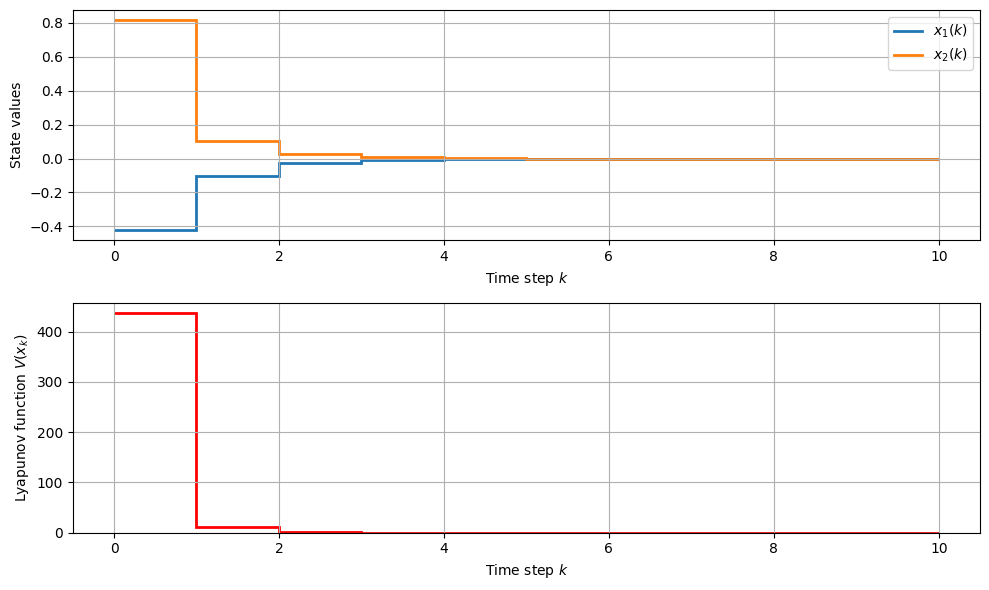

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# System matrices
A = np.array([[1.0, 1.0],[0.5,1.0]])
B = np.array([[1.0],[1.0]])

# Initial condition
x0 = np.random.randn(2)

# Number of time steps
N = 10

# Initialize arrays to store values of x and V(x)
x_values = []
V_values = []

# Set initial condition
x_k = x0

# Simulate the system and compute the Lyapunov function
for k in range(N):
    x_values.append(x_k)  # Store the state
    V_k = x_k.T @ Qinv @ x_k  # Compute the Lyapunov function V(x_k)
    V_values.append(V_k)

    # Update the state using x_{k+1} = A * x_k
    x_k = (A+B@K) @ x_k

x_values = np.array(x_values)
V_values = np.array(V_values)

# Plot the state trajectories
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.stairs(x_values[:, 0], label='$x_1(k)$', linewidth=2, baseline=None)
plt.stairs(x_values[:, 1], label='$x_2(k)$', linewidth=2, baseline=None)
plt.xlabel('Time step $k$')
plt.ylabel('State values')
plt.grid(True)
plt.legend()

# Plot the Lyapunov function V(x_k) using stairs
plt.subplot(2, 1, 2)
plt.stairs(V_values, label='$V(x_k) = x_k^T P x_k$', color='r', linewidth=2, baseline=None)
plt.xlabel('Time step $k$')
plt.ylabel('Lyapunov function $V(x_k)$')
plt.grid(True)

plt.tight_layout()
plt.show()

